Create spark session

In [1]:
import sys, glob, os
SPARK_HOME = "/Users/abulbasar/Downloads/spark-2.3.1-bin-hadoop2.7"
sys.path.append(SPARK_HOME + "/python")
sys.path.append(glob.glob(SPARK_HOME + "/python/lib/py4j*.zip")[0])
from pyspark.sql import SparkSession, functions as F
spark = (SparkSession
         .builder
         .config("spark.master", "local[*]")
         .config("spark.driver.memory", "4G")
         .config("spark.sql.shuffle.partitions", 16)
         .getOrCreate())
sc = spark.sparkContext
print(sc.uiWebUrl)
sql = spark.sql

http://abuls-mbp-5:4040


Create utility function to load data into a spark dataframe

In [2]:
import re
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline 

base_dir = "/data/movielens/"

def cache_df(df, name):
    df.createOrReplaceTempView(name)
    spark.catalog.cacheTable(name)
    
def load(file):
    name = re.sub("[^A-Za-z0-9]", "_", file[:-4])
    df = spark.read.option("header", True).option("inferSchema", True).csv(base_dir + file)
    cache_df(df, name)
    df.alias(name)
    return df

Load data

In [80]:
movies = load("movies.csv")
ratings = load("ratings.csv")

sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        | df_train|       true|
|        |   movies|       true|
|        |  ratings|       true|
+--------+---------+-----------+



Take a look at movies dataset. It shows by default first 20 records.

In [4]:
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

View the ratings data.

In [5]:
ratings.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
+------+-------+------+----------+
only showing top 20 rows



How many rating levels are there? Find count by each rating level

In [75]:
ratings.groupBy("rating").count().toPandas().sort_values("rating")

,rating,count
4,0.5,1101
1,1.0,3326
2,1.5,1687
9,2.0,7271
0,2.5,4449
8,3.0,20064
6,3.5,10538
5,4.0,28750
7,4.5,7723
3,5.0,15095


Change the fraction rating values to intger to reduce the number of rating.

In [77]:
ratings = ratings.withColumn("rating", F.expr("cast(rating as int)"))
ratings.groupBy("rating").count().toPandas().sort_values("rating")

,rating,count
5,0,1101
2,1,5013
3,2,11720
1,3,30602
4,4,36473
0,5,15095


Find the distribution of rating by plotting histogram.

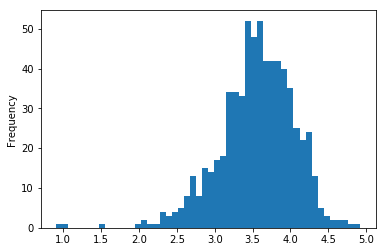

In [78]:
ratings.groupBy("userId").agg(F.avg("rating").alias("avg_rating")).toPandas().avg_rating.plot.hist(bins = 50)

How the average rating have changed over years.

Text(0,0.5,'Avg Rating')

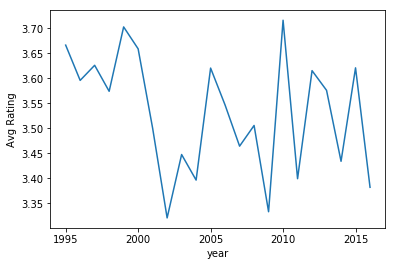

In [7]:
avg_rating_by_year = (ratings
 .withColumn("year", F.expr("year(from_unixtime(timestamp))"))
 .groupBy("year")
 .agg(F.avg("rating").alias("avg_rating"))
).toPandas()

avg_rating_by_year = avg_rating_by_year.sort_values("year")
avg_rating_by_year.index = avg_rating_by_year.year

avg_rating_by_year.avg_rating.plot()

plt.ylabel("Avg Rating")

Find number of unique users.

In [8]:
ratings.selectExpr("count(distinct userId)").first()

Row(count(DISTINCT userId)=671)

Find number of unique movieIds.

In [81]:
ratings.selectExpr("count(distinct movieId)").first()

Row(count(DISTINCT movieId)=9066)

Does all the movie id mentioned in rating present in the movies table as well? Expected count from the statement below should be 0, if all values are present. 

In [10]:
ratings.join(movies, on = ["movieId"], how = "leftanti").show()

+-------+------+------+---------+
|movieId|userId|rating|timestamp|
+-------+------+------+---------+
+-------+------+------+---------+



What is distribution of the number of rating by each movie

In [11]:
ratings.groupBy("movieId").count().select("count").describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|              9066|
|   mean|11.030664019413193|
| stddev|24.050799967665892|
|    min|                 1|
|    max|               341|
+-------+------------------+



Find the average rating by each user and rating count.

In [12]:
avg_rating = ratings.groupBy("userId").agg(F.count("*").alias("count"), F.avg("rating").alias("avg_rating"))
avg_rating.show()

+------+-----+------------------+
|userId|count|        avg_rating|
+------+-----+------------------+
|    12|   61|2.7540983606557377|
|    18|   51| 3.235294117647059|
|    38|  111| 4.292792792792793|
|    67|  103|3.7572815533980584|
|    70|   83| 4.204819277108434|
|    93|  159|  3.79874213836478|
|   161|   90| 3.588888888888889|
|   186|   42|3.7976190476190474|
|   190|   60|               4.0|
|   218|   42| 3.892857142857143|
|   225|   28| 4.107142857142857|
|   257|  103|3.6067961165048543|
|   261|   50|              3.63|
|   263|  114| 3.254385964912281|
|   273|   92| 4.309782608695652|
|   275|  202| 4.452970297029703|
|   280|   22| 4.318181818181818|
|   295|  236| 3.944915254237288|
|   300|   44| 4.056818181818182|
|   317|   22|               3.5|
+------+-----+------------------+
only showing top 20 rows



Which movies are more consistent rating from users. We can take standard deviation as measure of consistency. 

In [87]:
(ratings.groupBy("movieId").agg(F.avg("rating")
                               , F.stddev("rating").alias("std")
                               , F.count("*").alias("count"))
 .filter("not isnan(std)")
 .orderBy(F.desc("std"))).show()

+-------+-----------+------------------+-----+
|movieId|avg(rating)|               std|count|
+-------+-----------+------------------+-----+
|   2483|       2.75| 3.181980515339464|    2|
|  27178|       2.75| 3.181980515339464|    2|
|   6219|       2.75| 3.181980515339464|    2|
|   5179|        3.0|2.8284271247461903|    2|
|   3718|        3.0|2.8284271247461903|    2|
|   3892|        3.0|2.8284271247461903|    2|
|   4404|        3.0|2.8284271247461903|    2|
|  91104|        2.5|2.8284271247461903|    2|
|  66246|        2.5|2.8284271247461903|    2|
|   4562|        3.0|2.8284271247461903|    2|
|   4630|        3.0|2.8284271247461903|    2|
|   2824|        3.0|2.8284271247461903|    2|
| 135436|        3.0|2.8284271247461903|    2|
|   3490|        3.0|2.8284271247461903|    2|
|  98122|       2.25|2.4748737341529163|    2|
|   4768|       2.75|2.4748737341529163|    2|
|   7577|       2.25|2.4748737341529163|    2|
|  31364|       2.25|2.4748737341529163|    2|
|  87522|    

Devide the dataset into training and test

In [13]:
df_train, df_test = (ratings.randomSplit([0.7, 0.3], seed = 1))
cache_df(df_train, "df_train")

Apply matrix factorization using ALS (alternate least square) from mllib

In [14]:
from pyspark.ml.recommendation import ALS

In [15]:
als = ALS(rank=10, maxIter=5, seed=0, userCol= "userId", itemCol= "movieId", ratingCol="rating")
als_model = als.fit(df_train)

View the iterm factors. These factors are found by ALS model. These represent latent properties of the each movie. Rank or the dimension is 10 as we specied in the ALS model.

In [16]:
als_model.itemFactors.limit(10).toPandas()

,id,features
0,10,"[-0.6567551493644714, 0.17023585736751556, 0.1..."
1,20,"[-0.4997054636478424, 0.7629446983337402, 0.35..."
2,30,"[-1.2382067441940308, 0.31346645951271057, -0...."
3,40,"[-0.5878310203552246, -0.03554472327232361, -0..."
4,50,"[-0.9105768203735352, -0.29635462164878845, -0..."
5,60,"[-0.7227060198783875, 0.15587139129638672, 0.1..."
6,70,"[-0.7075935006141663, -0.5955221056938171, -0...."
7,80,"[-1.216125249862671, -0.710476279258728, -0.97..."
8,100,"[-1.0151256322860718, 0.1099018082022667, 0.49..."
9,110,"[-0.5864070653915405, -0.11984661221504211, -0..."


Find all the movies by userId = 100. It is just example user.

In [17]:
ratings.filter("userId = 100").join(movies, on = "movieId").orderBy(F.desc("rating")).show()

+-------+------+------+---------+--------------------+--------------------+
|movieId|userId|rating|timestamp|               title|              genres|
+-------+------+------+---------+--------------------+--------------------+
|     32|   100|   5.0|854193977|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|
|   1073|   100|   5.0|854194056|Willy Wonka & the...|Children|Comedy|F...|
|      3|   100|   4.0|854194024|Grumpier Old Men ...|      Comedy|Romance|
|    608|   100|   4.0|854194024|        Fargo (1996)|Comedy|Crime|Dram...|
|    745|   100|   4.0|854194208|Wallace & Gromit:...|Animation|Childre...|
|    802|   100|   4.0|854194111|   Phenomenon (1996)|       Drama|Romance|
|   1356|   100|   4.0|854194086|Star Trek: First ...|Action|Adventure|...|
|     25|   100|   4.0|854193977|Leaving Las Vegas...|       Drama|Romance|
|      1|   100|   4.0|854193977|    Toy Story (1995)|Adventure|Animati...|
|      6|   100|   3.0|854194023|         Heat (1995)|Action|Crime|Thri...|
|      7|   

We see movieId = 32 has been one the top rated movie for user = 100. Find out movies similar to this movie = 32. For similarity consine similarity has been used on the iterm vectors. 

In [18]:
from pyspark.sql.types import DoubleType
import numpy as np
import scipy
import scipy.spatial

def distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return float(scipy.spatial.distance.cosine(v1, v2))

spark.udf.register("distance", distance, DoubleType())

(als_model
 .itemFactors
 .filter(F.col("id") == 32)
 .alias("t1")
 .crossJoin(als_model.itemFactors.alias("t2"))
 .withColumn("similarity", F.expr("distance(t1.features, t2.features)")) 
 .join(movies, F.col("t2.id") == F.col("movieId"))
 .orderBy(F.asc("similarity"))
 .select("movieId", "title", "similarity")
).show(10, False)

+-------+----------------------------------------------+--------------------+
|movieId|title                                         |similarity          |
+-------+----------------------------------------------+--------------------+
|32     |Twelve Monkeys (a.k.a. 12 Monkeys) (1995)     |0.0                 |
|46322  |Jet Li's Fearless (Huo Yuan Jia) (2006)       |0.0062189570119211  |
|98124  |Batman: The Dark Knight Returns, Part 1 (2012)|0.010647798173433975|
|6093   |Last Unicorn, The (1982)                      |0.013341269621749863|
|8879   |Murder on the Orient Express (1974)           |0.013668733196542382|
|47999  |Jesus Camp (2006)                             |0.014516203536842132|
|6807   |Monty Python's The Meaning of Life (1983)     |0.015039268043464116|
|5655   |Fan, The (1981)                               |0.016229203198995457|
|5682   |Grey Zone, The (2001)                         |0.016229203198995457|
|33437  |Unleashed (Danny the Dog) (2005)              |0.016229

Similarly we can see the user factors representing the latent propeties of the user.

In [19]:
als_model.userFactors.limit(10).toPandas()

,id,features
0,10,"[-0.27453291416168213, 0.4721890389919281, 0.0..."
1,20,"[-1.0165343284606934, 0.01221226342022419, 0.1..."
2,30,"[-0.4337976276874542, 0.39221954345703125, -0...."
3,40,"[-0.2449049949645996, -0.39294686913490295, 0...."
4,50,"[-0.5823224186897278, 0.30906781554222107, 0.1..."
5,60,"[-0.4005112946033478, -0.3106009364128113, -0...."
6,70,"[-0.8395317792892456, 0.15928272902965546, 0.3..."
7,80,"[-0.728884756565094, -0.5794251561164856, -0.0..."
8,90,"[-0.4736209511756897, -0.100474514067173, 0.21..."
9,100,"[-0.5826367139816284, 0.10884485393762589, -0...."


Predict the rating for each movie and user combination in the df_test dataset.

In [20]:
df_prediction = als_model.transform(df_test)
df_prediction.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   157|     12|   2.0|1291598164| 2.3615606|
|   564|     12|   1.0| 974709821|  2.962479|
|    91|     12|   3.5|1448813887| 3.7231722|
|   624|     12|   2.0|1019563753| 2.1231043|
|   636|     18|   3.0| 855227364| 3.6876078|
|   616|     18|   4.0| 860573132| 3.3237486|
|   571|     18|   5.0|1334342436|  2.984219|
|   135|     18|   4.0| 844996129| 2.9966164|
|   255|     18|   2.5|1236980522| 2.6255386|
|   461|     18|   1.5|1091959887| 2.8265314|
|   408|     18|   5.0| 933116210|  2.465368|
|   507|     18|   4.0| 862091839| 3.7877188|
|   177|     18|   4.0| 907380994| 4.0937204|
|    30|     18|   2.0| 945277971| 3.4956696|
|   655|     18|   4.0|1470073389| 3.5190122|
|   165|     70|   5.0|1111480089|  2.729212|
|   358|     70|   1.0| 957534713| 2.4271307|
|    34|     70|   4.0| 973746231|  3.272626|
|   580|     70|   2.5|1165292373|

Find predictions of rating for user 575 and compare it against the actual rating. 

In [21]:
df_prediction.filter("userId = 575").show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   575|    613|   4.0|1012594056| 3.0562854|
|   575|    912|   5.0|1012593307| 3.9839513|
|   575|   1256|   5.0|1012595762| 3.5357132|
|   575|   1479|   2.0|1012594286|  2.448181|
|   575|   1943|   3.0|1012606205| 2.9540071|
|   575|   2716|   5.0|1012593003| 3.3577695|
|   575|   2728|   3.0|1012604429| 3.7834008|
|   575|   2968|   5.0|1012597696|  3.311494|
|   575|   3196|   4.0|1012604409| 4.0493655|
|   575|   3516|   3.0|1018056630| 2.1874354|
|   575|   5232|   4.0|1018058258|       NaN|
|   575|    539|   3.0|1012593690|  3.086885|
|   575|    913|   5.0|1012593062| 3.9459794|
|   575|   1022|   4.0|1012594848| 3.2176213|
|   575|   1597|   4.0|1012594028|   2.37563|
|   575|   2099|   3.0|1012594848| 4.1476636|
|   575|   3244|   4.0|1012596068| 3.0872905|
|   575|   3421|   3.0|1012595812|  3.539041|
|   575|   5034|   5.0|1012593616|

For for some movie prediction is nan. Those movies may not have any records in the df_train.

In [92]:
df_prediction.filter("isnan(prediction)").orderBy("movieId").show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   311|     83|   3.0| 898008016|       NaN|
|   514|     83|   3.0| 853893246|       NaN|
|   383|     83|   3.0| 852809207|       NaN|
|   564|    108|   4.0| 974713920|       NaN|
|   555|    114|   3.0| 857379668|       NaN|
|   452|    119|   3.0| 976423036|       NaN|
|    86|    124|   3.0| 848161391|       NaN|
|   665|    129|   3.0| 995232528|       NaN|
|    41|    130|   4.5|1093889645|       NaN|
|   575|    148|   4.0|1012605106|       NaN|
|   564|    184|   5.0| 974715756|       NaN|
|   254|    184|   4.0| 845158097|       NaN|
|   439|    187|   2.0|1041115023|       NaN|
|   393|    187|   3.5|1058472448|       NaN|
|   312|    187|   3.0| 959930966|       NaN|
|   564|    189|   4.0| 974838288|       NaN|
|   182|    243|   4.0| 845745917|       NaN|
|   647|    245|   3.0| 947292322|       NaN|
|   516|    251|   3.0| 844687985|

In [22]:
df_prediction.filter("movieId = 148").show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   575|    148|   4.0|1012605106|       NaN|
+------+-------+------+----------+----------+



In [23]:
df_train.filter("movieId = 148").show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
+------+-------+------+---------+



In [24]:
als_model.itemFactors.filter("id = 148").show()

+---+--------+
| id|features|
+---+--------+
+---+--------+



In [25]:
recommendations_by_user = als_model.recommendForAllUsers(10)
recommendations_by_user.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    70|[[3153, 6.02181],...|
|   190|[[83411, 6.084129...|
|   280|[[67504, 5.802005...|
|   300|[[65037, 5.451367...|
|   340|[[121231, 5.38031...|
|   600|[[121231, 5.44495...|
|   640|[[1948, 5.232915]...|
|   660|[[8530, 5.3535943...|
|   161|[[2924, 4.9626007...|
|   261|[[7502, 5.934217]...|
|   471|[[8530, 5.079349]...|
|   581|[[6413, 4.8211713...|
|   611|[[121231, 5.59576...|
|   641|[[6413, 5.5095477...|
|    12|[[4467, 5.0954275...|
|   412|[[3414, 5.187823]...|
|   452|[[83318, 4.957124...|
|   612|[[5114, 4.624316]...|
|   662|[[6413, 5.0597777...|
|    93|[[83318, 5.213915...|
+------+--------------------+
only showing top 20 rows



In [26]:
# Most active users

In [27]:
rating_count_by_user = (ratings
 .groupBy("userId")
 .agg(F.avg("rating").alias("avg_rating")
      , F.count("*").alias("rating_count")
      , F.stddev("rating").alias("std_rating")
     )
 .orderBy(F.desc("rating_count"))
)

rating_count_by_user.show()

+------+------------------+------------+------------------+
|userId|        avg_rating|rating_count|        std_rating|
+------+------------------+------------+------------------+
|   547|3.3667921371810956|        2391|1.0735159642009127|
|   564|3.5524625267665955|        1868|1.1718577106638184|
|   624| 2.894236311239193|        1735|1.0271241705713352|
|    15|2.6217647058823528|        1700|1.2590565864427354|
|    73| 3.374223602484472|        1610|0.9452969120978967|
|   452| 3.189179104477612|        1340|1.0167723747219453|
|   468|2.9659178931061194|        1291|0.7650304687131316|
|   380|3.3664158043273753|        1063|0.8985922471106201|
|   311| 3.006378802747792|        1019|0.9165625850322938|
|    30| 3.765084075173096|        1011|0.9259501236774199|
|   294| 3.584477296726505|         947|0.6500461979532272|
|   509| 3.366738894907909|         923|0.9376488365288455|
|   580| 3.272776572668113|         922|0.8112581159527509|
|   213|2.6604395604395603|         910|

In [28]:
rating_count_by_user.selectExpr("mean(std_rating)").first()

Row(avg(std_rating)=0.9397575962390582)

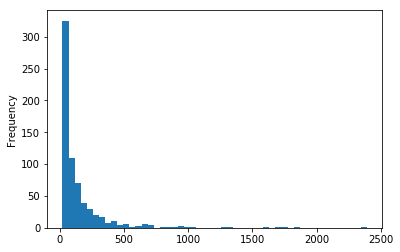

In [29]:
rating_count_by_user.select("rating_count").toPandas()["rating_count"].plot.hist(bins = 50)

In [30]:
recommendations_by_user.filter("id = 547").first()

Row(userId=547, recommendations=[Row(movieId=83411, rating=5.173189640045166), Row(movieId=67504, rating=5.173189640045166), Row(movieId=83318, rating=5.173189640045166), Row(movieId=83359, rating=5.173189640045166), Row(movieId=96075, rating=5.025032043457031), Row(movieId=8261, rating=5.025032043457031), Row(movieId=8123, rating=5.025032043457031), Row(movieId=26501, rating=5.025032043457031), Row(movieId=150856, rating=5.025032043457031), Row(movieId=101850, rating=5.025032043457031)])

In [31]:
recommendations_by_user_enriched = (recommendations_by_user
.withColumn("recommendation", F.explode("recommendations"))
.withColumn("movieId", F.expr("recommendation.movieId"))
.withColumn("recommended_rating", F.expr("recommendation.rating"))
.drop("recommendations")
.drop("recommendation")
.join(movies, on = "movieId")
)

recommendations_by_user_enriched.show()

+-------+------+------------------+--------------------+--------------------+
|movieId|userId|recommended_rating|               title|              genres|
+-------+------+------------------+--------------------+--------------------+
|   3153|    70|           6.02181|7th Voyage of Sin...|Action|Adventure|...|
|  83411|    70|         6.0172696|         Cops (1922)|              Comedy|
|  67504|    70|         6.0172696|Land of Silence a...|         Documentary|
|  83318|    70|         6.0172696|    Goat, The (1921)|              Comedy|
|  83359|    70|         6.0172696|Play House, The (...|              Comedy|
|   8580|    70|         5.9748297|Into the Woods (1...|Adventure|Comedy|...|
|   6375|    70|          5.880907|Gigantic (A Tale ...|         Documentary|
|   2924|    70|         5.7831845|Drunken Master (J...|       Action|Comedy|
|   2920|    70|           5.75577|Children of Parad...|       Drama|Romance|
|   1564|    70|          5.725449|For Roseanna (Ros...|Comedy|D

In [32]:
recommendations_by_user_enriched.filter("userId = 547").show()

+-------+------+------------------+--------------------+-----------------+
|movieId|userId|recommended_rating|               title|           genres|
+-------+------+------------------+--------------------+-----------------+
|  83411|   547|         5.1731896|         Cops (1922)|           Comedy|
|  67504|   547|         5.1731896|Land of Silence a...|      Documentary|
|  83318|   547|         5.1731896|    Goat, The (1921)|           Comedy|
|  83359|   547|         5.1731896|Play House, The (...|           Comedy|
|  96075|   547|          5.025032|  Bleak House (2005)|            Drama|
|   8261|   547|          5.025032|3 Women (Three Wo...|            Drama|
|   8123|   547|          5.025032|Sammy and Rosie G...|     Comedy|Drama|
|  26501|   547|          5.025032|    Choose Me (1984)|   Comedy|Romance|
| 150856|   547|          5.025032|Making a Murderer...|      Documentary|
| 101850|   547|          5.025032|Death on the Stai...|Crime|Documentary|
+-------+------+---------

In [33]:
movies_ratings = ratings.join(movies, on = "movieId")

In [34]:
movies_ratings.filter("userId = 547").orderBy(F.desc("rating")).show()

+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|    903|   547|   5.0| 974777443|      Vertigo (1958)|Drama|Mystery|Rom...|
|   1028|   547|   5.0| 974780614| Mary Poppins (1964)|Children|Comedy|F...|
|    904|   547|   5.0| 974777410|  Rear Window (1954)|    Mystery|Thriller|
|    902|   547|   5.0| 974810254|Breakfast at Tiff...|       Drama|Romance|
|    908|   547|   5.0| 974777109|North by Northwes...|Action|Adventure|...|
|    125|   547|   5.0|1370674374|Flirting With Dis...|              Comedy|
|    909|   547|   5.0| 974780397|Apartment, The (1...|Comedy|Drama|Romance|
|    194|   547|   5.0| 986695368|        Smoke (1995)|        Comedy|Drama|
|    910|   547|   5.0| 974777443|Some Like It Hot ...|        Comedy|Crime|
|     17|   547|   5.0| 974778941|Sense and Sensibi...|       Drama|Romance|

In [35]:
movies_ratings.filter("userId = 547").show()

+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|      1|   547|   3.5|1053173138|    Toy Story (1995)|Adventure|Animati...|
|      6|   547|   2.5|1149462857|         Heat (1995)|Action|Crime|Thri...|
|      7|   547|   2.0|1021098817|      Sabrina (1995)|      Comedy|Romance|
|     11|   547|   3.0|1418149949|American Presiden...|Comedy|Drama|Romance|
|     14|   547|   3.5|1053171195|        Nixon (1995)|               Drama|
|     16|   547|   4.0| 986694981|       Casino (1995)|         Crime|Drama|
|     17|   547|   5.0| 974778941|Sense and Sensibi...|       Drama|Romance|
|     21|   547|   4.0| 974809441|   Get Shorty (1995)|Comedy|Crime|Thri...|
|     25|   547|   4.5|1053087861|Leaving Las Vegas...|       Drama|Romance|
|     32|   547|   4.0| 981314489|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|

In [36]:
recommendations_by_user_enriched.filter("userId = 547").show()

+-------+------+------------------+--------------------+-----------------+
|movieId|userId|recommended_rating|               title|           genres|
+-------+------+------------------+--------------------+-----------------+
|  83411|   547|         5.1731896|         Cops (1922)|           Comedy|
|  67504|   547|         5.1731896|Land of Silence a...|      Documentary|
|  83318|   547|         5.1731896|    Goat, The (1921)|           Comedy|
|  83359|   547|         5.1731896|Play House, The (...|           Comedy|
|  96075|   547|          5.025032|  Bleak House (2005)|            Drama|
|   8261|   547|          5.025032|3 Women (Three Wo...|            Drama|
|   8123|   547|          5.025032|Sammy and Rosie G...|     Comedy|Drama|
|  26501|   547|          5.025032|    Choose Me (1984)|   Comedy|Romance|
| 150856|   547|          5.025032|Making a Murderer...|      Documentary|
| 101850|   547|          5.025032|Death on the Stai...|Crime|Documentary|
+-------+------+---------

In [37]:
(movies_ratings.filter("userId = 547")
 .join(recommendations_by_user_enriched.filter("userId = 547"), on = "movieId", how = "leftanti")
 .orderBy(F.desc("rating"))
).limit(10).toPandas()

,movieId,userId,rating,timestamp,title,genres
0,928,547,5.0,974810654,Rebecca (1940),Drama|Mystery|Romance|Thriller
1,3152,547,5.0,974809988,"Last Picture Show, The (1971)",Drama
2,904,547,5.0,974777410,Rear Window (1954),Mystery|Thriller
3,2612,547,5.0,974810080,Mildred Pierce (1945),Drama|Film-Noir
4,448,547,5.0,981314419,Fearless (1993),Drama
5,5017,547,5.0,1094983691,"Big Heat, The (1953)",Drama|Film-Noir
6,7116,547,5.0,1071595779,Diabolique (Les diaboliques) (1955),Horror|Mystery|Thriller
7,53887,547,5.0,1201361739,O Lucky Man! (1973),Comedy|Drama|Fantasy|Musical
8,86487,547,5.0,1351010563,Mildred Pierce (2011),Drama
9,2732,547,5.0,974809963,Jules and Jim (Jules et Jim) (1961),Drama|Romance


In [38]:
def reco_for_user(userId): 
    return (als_model
     .recommendForUserSubset(df_train.filter(F.col("userId") == userId), 500)
     .withColumn("recommendation", F.explode("recommendations"))
     .withColumn("movieId", F.expr("recommendation.movieId"))
     .withColumn("recommended_rating", F.expr("recommendation.rating"))
     .drop("recommendations")
     .drop("recommendation")
     .join(ratings.filter(F.col("userId") == userId), on = "movieId", how = "leftanti")
     .join(movies, on = "movieId")
     .orderBy(F.desc("recommended_rating"))
    )
reco_for_user(547).show()

+-------+------+------------------+--------------------+--------------------+
|movieId|userId|recommended_rating|               title|              genres|
+-------+------+------------------+--------------------+--------------------+
|  67504|   547|         5.1731896|Land of Silence a...|         Documentary|
|  83359|   547|         5.1731896|Play House, The (...|              Comedy|
|  83318|   547|         5.1731896|    Goat, The (1921)|              Comedy|
|  83411|   547|         5.1731896|         Cops (1922)|              Comedy|
|   8609|   547|          4.655871|Our Hospitality (...|              Comedy|
|  26400|   547|          4.655871|Gates of Heaven (...|         Documentary|
|  25764|   547|          4.655871|Cameraman, The (1...|Comedy|Drama|Romance|
|  72647|   547|          4.655871| Zorn's Lemma (1970)|               Drama|
|  31547|   547|          4.655871|Lessons of Darkne...|     Documentary|War|
|  80599|   547|          4.655871|Buster Keaton: A ...|        

In [39]:
rating_count_by_user.filter("rating_count = 25").show()

+------+----------+------------+-------------------+
|userId|avg_rating|rating_count|         std_rating|
+------+----------+------------+-------------------+
|   331|      3.58|          25| 1.2389511693363868|
|   375|      3.56|          25|  1.260952021291849|
|   377|      3.36|          25| 0.8602325267042628|
|   637|      4.14|          25| 0.8602325267042628|
|    44|      3.36|          25| 0.8602325267042625|
|   114|      4.08|          25| 1.0376254944182253|
|   100|       3.4|          25| 0.7071067811865476|
|   269|       3.4|          25| 1.0801234497346432|
|   392|      3.04|          25|  1.107925990308017|
|   446|      4.62|          25|0.38944404818493067|
|   556|       4.4|          25| 0.7637626158259734|
|   538|       3.6|          25| 1.0408329997330665|
|   116|       3.9|          25| 1.3070322617798436|
|   495|      4.08|          25| 0.7593857166596345|
+------+----------+------------+-------------------+



In [40]:
reco_for_user(100).show()

+-------+------+------------------+--------------------+--------------------+
|movieId|userId|recommended_rating|               title|              genres|
+-------+------+------------------+--------------------+--------------------+
|  83359|   100|         5.2522883|Play House, The (...|              Comedy|
|  83318|   100|         5.2522883|    Goat, The (1921)|              Comedy|
|  83411|   100|         5.2522883|         Cops (1922)|              Comedy|
|  67504|   100|         5.2522883|Land of Silence a...|         Documentary|
|   5114|   100|          5.080011|Bad and the Beaut...|               Drama|
|   4518|   100|          4.990545|The Lair of the W...|       Comedy|Horror|
|   2202|   100|           4.90312|     Lifeboat (1944)|           Drama|War|
|   2920|   100|         4.7948914|Children of Parad...|       Drama|Romance|
|    390|   100|          4.776206|Faster Pussycat! ...|  Action|Crime|Drama|
|  47728|   100|         4.7395673|Green for Danger ...|       C

In [41]:
als_model.transform(df_test).show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   157|     12|   2.0|1291598164| 2.3615606|
|   564|     12|   1.0| 974709821|  2.962479|
|    91|     12|   3.5|1448813887| 3.7231722|
|   624|     12|   2.0|1019563753| 2.1231043|
|   636|     18|   3.0| 855227364| 3.6876078|
|   616|     18|   4.0| 860573132| 3.3237486|
|   571|     18|   5.0|1334342436|  2.984219|
|   135|     18|   4.0| 844996129| 2.9966164|
|   255|     18|   2.5|1236980522| 2.6255386|
|   461|     18|   1.5|1091959887| 2.8265314|
|   408|     18|   5.0| 933116210|  2.465368|
|   507|     18|   4.0| 862091839| 3.7877188|
|   177|     18|   4.0| 907380994| 4.0937204|
|    30|     18|   2.0| 945277971| 3.4956696|
|   655|     18|   4.0|1470073389| 3.5190122|
|   165|     70|   5.0|1111480089|  2.729212|
|   358|     70|   1.0| 957534713| 2.4271307|
|    34|     70|   4.0| 973746231|  3.272626|
|   580|     70|   2.5|1165292373|

In [42]:
# Evaluation 

### Root mean squared error

In [43]:
(als_model
.transform(df_test)
.filter("not isnan(prediction)")
.selectExpr("sqrt(avg(pow((rating - prediction), 2))) test_rmse")
).show()

+------------------+
|         test_rmse|
+------------------+
|0.9378743807231806|
+------------------+



In [44]:
(als_model
.transform(df_train)
.filter("not isnan(prediction)")
.selectExpr("sqrt(avg(pow((rating - prediction), 2))) train_rmse")
).show()

+------------------+
|        train_rmse|
+------------------+
|0.5795429076794827|
+------------------+



In [45]:
genre_rating = (movies
.withColumn("year", F.regexp_extract("title", r"(\d+)", 1))
.withColumn("genres", F.split("genres", "\|"))
.withColumn("genre", F.explode("genres"))
.join(ratings, on = "movieId")
.withColumn("timestamp", F.expr("from_unixtime(timestamp)"))
)

genre_rating.show() 

+-------+--------------------+--------------------+----+---------+------+------+-------------------+
|movieId|               title|              genres|year|    genre|userId|rating|          timestamp|
+-------+--------------------+--------------------+----+---------+------+------+-------------------+
|     31|Dangerous Minds (...|             [Drama]|1995|    Drama|     1|   2.5|2009-12-14 08:22:24|
|   1029|        Dumbo (1941)|[Animation, Child...|1941|  Musical|     1|   3.0|2009-12-14 08:22:59|
|   1029|        Dumbo (1941)|[Animation, Child...|1941|    Drama|     1|   3.0|2009-12-14 08:22:59|
|   1029|        Dumbo (1941)|[Animation, Child...|1941| Children|     1|   3.0|2009-12-14 08:22:59|
|   1029|        Dumbo (1941)|[Animation, Child...|1941|Animation|     1|   3.0|2009-12-14 08:22:59|
|   1061|     Sleepers (1996)|          [Thriller]|1996| Thriller|     1|   3.0|2009-12-14 08:23:02|
|   1129|Escape from New Y...|[Action, Adventur...|1981| Thriller|     1|   2.0|2009-12-14 

Number of unique values of the genres

In [46]:
genre_rating.selectExpr("count(distinct genre)").first()

Row(count(DISTINCT genre)=20)

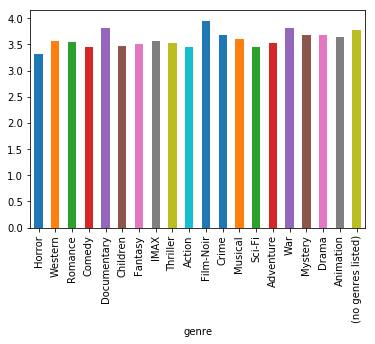

In [47]:
avg_rating_by_genre = genre_rating.groupBy("genre").avg("rating").toPandas()
avg_rating_by_genre.index = avg_rating_by_genre["genre"]
avg_rating_by_genre["avg(rating)"].plot.bar()

In [48]:
movie_genre_stats = (genre_rating
 .withColumn("rating_avg", F.expr("avg(rating) over (partition by genre)"))
 .withColumn("rating_count", F.expr("count(*) over (partition by genre)"))
 .withColumn("rating_count", F.log("rating_count"))
 .withColumn("rating_std", F.expr("stddev(rating) over (partition by genre)"))
 .withColumn("unique_user_count_rank", F.expr("dense_rank() over (partition by genre order by userId)"))
 .withColumn("unique_user_count", F.expr("max(unique_user_count_rank) over (partition by genre)"))
 .withColumn("unique_user_count", F.log("unique_user_count"))
 .withColumn("high_rating", F.expr("sum(if(rating = 4 or rating = 5, 1, 0)) over (partition by genre)"))
 .withColumn("high_rating", F.expr("log(high_rating)"))
 .drop("unique_user_count_rank")
)
movie_genre_stats.limit(10).toPandas()

,movieId,title,genres,year,genre,userId,rating,timestamp,rating_avg,rating_count,rating_std,unique_user_count,high_rating
0,1339,Dracula (Bram Stoker's Dracula) (1992),"[Fantasy, Horror, Romance, Thriller]",1992,Horror,1,3.5,2009-12-14 08:22:05,3.315243,8.823206,1.111409,6.388561,7.796469
1,2455,"Fly, The (1986)","[Drama, Horror, Sci-Fi, Thriller]",1986,Horror,1,2.5,2009-12-14 08:21:53,3.315243,8.823206,1.111409,6.388561,7.796469
2,253,Interview with the Vampire: The Vampire Chroni...,"[Drama, Horror]",1994,Horror,2,4.0,1996-06-21 16:41:51,3.315243,8.823206,1.111409,6.388561,7.796469
3,273,Mary Shelley's Frankenstein (Frankenstein) (1994),"[Drama, Horror, Sci-Fi]",1994,Horror,2,4.0,1996-06-21 16:46:19,3.315243,8.823206,1.111409,6.388561,7.796469
4,382,Wolf (1994),"[Drama, Horror, Romance, Thriller]",1994,Horror,2,3.0,1996-06-21 16:52:45,3.315243,8.823206,1.111409,6.388561,7.796469
5,593,"Silence of the Lambs, The (1991)","[Crime, Horror, Thriller]",1991,Horror,2,3.0,1996-06-21 16:41:51,3.315243,8.823206,1.111409,6.388561,7.796469
6,593,"Silence of the Lambs, The (1991)","[Crime, Horror, Thriller]",1991,Horror,3,3.0,2011-03-01 01:07:20,3.315243,8.823206,1.111409,6.388561,7.796469
7,2513,Pet Sematary (1989),[Horror],1989,Horror,3,3.0,2011-02-28 08:26:29,3.315243,8.823206,1.111409,6.388561,7.796469
8,2762,"Sixth Sense, The (1999)","[Drama, Horror, Mystery]",1999,Horror,3,3.5,2011-03-01 01:10:57,3.315243,8.823206,1.111409,6.388561,7.796469
9,2841,Stir of Echoes (1999),"[Horror, Mystery, Thriller]",1999,Horror,3,4.0,2011-02-28 08:25:33,3.315243,8.823206,1.111409,6.388561,7.796469


In [49]:
from pyspark.ml.feature import StringIndexer, IDF
from pyspark.ml.pipeline import Pipeline

In [50]:
genre_indexer = StringIndexer(inputCol="genre", outputCol="genre_index")
stats_by_genre_indexed = genre_indexer.fit(movie_genre_stats).transform(movie_genre_stats)
stats_by_genre_indexed.limit(5).toPandas()

,movieId,title,genres,year,genre,userId,rating,timestamp,rating_avg,rating_count,rating_std,unique_user_count,high_rating,genre_index
0,1339,Dracula (Bram Stoker's Dracula) (1992),"[Fantasy, Horror, Romance, Thriller]",1992,Horror,1,3.5,2009-12-14 08:22:05,3.315243,8.823206,1.111409,6.388561,7.796469,11.0
1,2455,"Fly, The (1986)","[Drama, Horror, Sci-Fi, Thriller]",1986,Horror,1,2.5,2009-12-14 08:21:53,3.315243,8.823206,1.111409,6.388561,7.796469,11.0
2,253,Interview with the Vampire: The Vampire Chroni...,"[Drama, Horror]",1994,Horror,2,4.0,1996-06-21 16:41:51,3.315243,8.823206,1.111409,6.388561,7.796469,11.0
3,273,Mary Shelley's Frankenstein (Frankenstein) (1994),"[Drama, Horror, Sci-Fi]",1994,Horror,2,4.0,1996-06-21 16:46:19,3.315243,8.823206,1.111409,6.388561,7.796469,11.0
4,382,Wolf (1994),"[Drama, Horror, Romance, Thriller]",1994,Horror,2,3.0,1996-06-21 16:52:45,3.315243,8.823206,1.111409,6.388561,7.796469,11.0


In [51]:
stats_by_genre_structed = (stats_by_genre_indexed
    .withColumn("rating_count_by_genre", F.struct("genre_index", F.col("rating_count").alias("value")))
    .withColumn("rating_avg_by_genre", F.struct("genre_index", F.col("rating_avg").alias("value")))
    .withColumn("rating_std_by_genre", F.struct("genre_index", F.col("rating_std").alias("value")))
    .withColumn("unique_user_count_by_genre", F.struct("genre_index", F.col("unique_user_count").alias("value")))
    .withColumn("high_rating_by_genre", F.struct("genre_index", F.col("high_rating").alias("value")))
    )
stats_by_genre_structed.limit(5).toPandas()

,movieId,title,genres,year,genre,userId,rating,timestamp,rating_avg,rating_count,rating_std,unique_user_count,high_rating,genre_index,rating_count_by_genre,rating_avg_by_genre,rating_std_by_genre,unique_user_count_by_genre,high_rating_by_genre
0,1339,Dracula (Bram Stoker's Dracula) (1992),"[Fantasy, Horror, Romance, Thriller]",1992,Horror,1,3.5,2009-12-14 08:22:05,3.315243,8.823206,1.111409,6.388561,7.796469,11.0,"(11.0, 8.823206220552741)","(11.0, 3.3152430044182624)","(11.0, 1.1114087425402719)","(11.0, 6.38856140554563)","(11.0, 7.796469243086058)"
1,2455,"Fly, The (1986)","[Drama, Horror, Sci-Fi, Thriller]",1986,Horror,1,2.5,2009-12-14 08:21:53,3.315243,8.823206,1.111409,6.388561,7.796469,11.0,"(11.0, 8.823206220552741)","(11.0, 3.3152430044182624)","(11.0, 1.1114087425402719)","(11.0, 6.38856140554563)","(11.0, 7.796469243086058)"
2,253,Interview with the Vampire: The Vampire Chroni...,"[Drama, Horror]",1994,Horror,2,4.0,1996-06-21 16:41:51,3.315243,8.823206,1.111409,6.388561,7.796469,11.0,"(11.0, 8.823206220552741)","(11.0, 3.3152430044182624)","(11.0, 1.1114087425402719)","(11.0, 6.38856140554563)","(11.0, 7.796469243086058)"
3,273,Mary Shelley's Frankenstein (Frankenstein) (1994),"[Drama, Horror, Sci-Fi]",1994,Horror,2,4.0,1996-06-21 16:46:19,3.315243,8.823206,1.111409,6.388561,7.796469,11.0,"(11.0, 8.823206220552741)","(11.0, 3.3152430044182624)","(11.0, 1.1114087425402719)","(11.0, 6.38856140554563)","(11.0, 7.796469243086058)"
4,382,Wolf (1994),"[Drama, Horror, Romance, Thriller]",1994,Horror,2,3.0,1996-06-21 16:52:45,3.315243,8.823206,1.111409,6.388561,7.796469,11.0,"(11.0, 8.823206220552741)","(11.0, 3.3152430044182624)","(11.0, 1.1114087425402719)","(11.0, 6.38856140554563)","(11.0, 7.796469243086058)"


In [52]:
stats_by_genre_grouped_by_user = (stats_by_genre_structed
                                   .groupBy("userId")
                                   .agg(
                                     F.collect_set("rating_count_by_genre").alias("rating_count_by_genre")
                                   , F.collect_set("rating_avg_by_genre").alias("rating_avg_by_genre")
                                   , F.collect_set("rating_std_by_genre").alias("rating_std_by_genre")
                                   , F.collect_set("unique_user_count_by_genre").alias("unique_user_count_by_genre")
                                   , F.collect_set("high_rating_by_genre").alias("high_rating_by_genre")
                                  ))

stats_by_genre_grouped_by_user.limit(5).toPandas()

,userId,rating_count_by_genre,rating_avg_by_genre,rating_std_by_genre,unique_user_count_by_genre,high_rating_by_genre
0,12,"[(10.0, 8.939187601475613), (2.0, 10.205664071...","[(11.0, 3.3152430044182624), (3.0, 3.518502377...","[(7.0, 1.0827948797862486), (16.0, 0.997528167...","[(17.0, 5.552959584921617), (1.0, 6.5072777123...","[(5.0, 9.067854723679428), (1.0, 9.64872432684..."
1,18,"[(10.0, 8.939187601475613), (2.0, 10.205664071...","[(11.0, 3.3152430044182624), (3.0, 3.518502377...","[(7.0, 1.0827948797862486), (6.0, 1.0269080753...","[(2.0, 6.508769136971682), (3.0, 6.50578406012...","[(5.0, 9.067854723679428), (1.0, 9.64872432684..."
2,38,"[(10.0, 8.939187601475613), (2.0, 10.205664071...","[(11.0, 3.3152430044182624), (3.0, 3.518502377...","[(7.0, 1.0827948797862486), (16.0, 0.997528167...","[(17.0, 5.552959584921617), (1.0, 6.5072777123...","[(5.0, 9.067854723679428), (1.0, 9.64872432684..."
3,67,"[(10.0, 8.939187601475613), (2.0, 10.205664071...","[(11.0, 3.3152430044182624), (3.0, 3.518502377...","[(7.0, 1.0827948797862486), (16.0, 0.997528167...","[(1.0, 6.507277712385012), (4.0, 6.50727771238...","[(5.0, 9.067854723679428), (1.0, 9.64872432684..."
4,70,"[(10.0, 8.939187601475613), (2.0, 10.205664071...","[(11.0, 3.3152430044182624), (3.0, 3.518502377...","[(7.0, 1.0827948797862486), (12.0, 1.009962234...","[(1.0, 6.507277712385012), (4.0, 6.50727771238...","[(5.0, 9.067854723679428), (1.0, 9.64872432684..."


In [53]:
stats_by_genre_grouped_by_user.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- rating_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_avg_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_std_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- unique_user_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- high_rating_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false

In [54]:
from pyspark.ml.linalg import SparseVector, VectorUDT

def to_vector(array_of_structs, size = 20):
    if array_of_structs is not None:
        array_of_structs = sorted(array_of_structs, key = lambda t: t.genre_index)
        indices = [s.genre_index for s in array_of_structs]
        values = [s.value for s in array_of_structs]
        return SparseVector(size, indices, values)
    return SparseVector(size, [], [])

spark.udf.register("to_vector", to_vector, VectorUDT())

<function __main__.to_vector(array_of_structs, size=20)>

In [55]:
stats_by_genre_grouped_by_user.columns

['userId',
 'rating_count_by_genre',
 'rating_avg_by_genre',
 'rating_std_by_genre',
 'unique_user_count_by_genre',
 'high_rating_by_genre']

In [58]:
stats_by_genre_grouped_by_user_vec = (stats_by_genre_grouped_by_user
            .withColumn("rating_count_by_genre_vec", F.expr("to_vector(rating_count_by_genre)"))
            .withColumn("rating_avg_by_genre_vec", F.expr("to_vector(rating_avg_by_genre)"))
            .withColumn("rating_std_by_genre_vec", F.expr("to_vector(rating_std_by_genre)"))
            .withColumn("unique_user_count_by_genre_vec", F.expr("to_vector(unique_user_count_by_genre)"))
            .withColumn("high_rating_by_genre_vec", F.expr("to_vector(high_rating_by_genre)"))
)
stats_by_genre_grouped_by_user_vec.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- rating_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_avg_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_std_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- unique_user_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- high_rating_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false

In [59]:
from pyspark.ml.feature import IDF
from pyspark.ml.pipeline import Pipeline

In [60]:
genres_count = genre_rating.selectExpr("count(distinct genre) count").first()["count"]
genres_count

20

In [64]:
pipe = Pipeline(stages = [
    IDF(inputCol="rating_count_by_genre_vec", outputCol="rating_count_by_genre_idf"),
    IDF(inputCol="rating_avg_by_genre_vec", outputCol="rating_avg_by_genre_idf"),
    IDF(inputCol= "rating_std_by_genre_vec", outputCol="rating_std_by_genre_idf"),
    IDF(inputCol="unique_user_count_by_genre_vec", outputCol="unique_user_by_genre_idf"),
    IDF(inputCol="high_rating_by_genre_vec", outputCol="high_rating_by_genre_idf")
])

user_profile_idf = pipe.fit(stats_by_genre_grouped_by_user_vec).transform(stats_by_genre_grouped_by_user_vec)

In [65]:
user_profile_idf.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- rating_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_avg_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_std_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- unique_user_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- high_rating_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false

In [66]:
enriched = (ratings
            .join(movies, on = "movieId")
            .join(user_profile_idf, on = "userId")
            .withColumn("rating", F.expr("cast(rating * 2 as int)"))
#            .withColumn("year", F.regexp_extract("title", r"\d+", 1))
#            .withColumn("age", F.expr("year(from_unixtime(timestamp)) - year"))
           )
enriched.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- rating_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_avg_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_std_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- unique_user_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |

In [67]:
from pyspark.ml.feature import VectorAssembler

In [68]:
vector_assembler = VectorAssembler(outputCol="features", inputCols=[
                                        'rating_count_by_genre_idf',
                                        'rating_avg_by_genre_idf',
                                        'rating_std_by_genre_idf',
                                        'unique_user_by_genre_idf',
                                        'high_rating_by_genre_idf'])
enriched_vec = vector_assembler.transform(enriched)

In [69]:
df_train, df_test = enriched_vec.randomSplit([0.7, 0.3], 1)
cache_df(df_train, "df_train")

In [70]:
df_train.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- rating_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_avg_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_std_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- unique_user_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |

In [71]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [72]:
lr = LogisticRegression(family="multinomial", maxIter=10, regParam=0.3
                    , elasticNetParam=0.8, featuresCol="features", labelCol="rating")

lr_model= lr.fit(df_train)
                
predictions = lr_model.transform(df_test)

evaluator = MulticlassClassificationEvaluator(
      labelCol="rating"
    , predictionCol="prediction"
    , metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test accuracy = %g " % (accuracy))

Test accuracy = 0.286947 


In [ ]:
df_train.select("rating").distinct().collect()